# Fitting and prediting - Time data

A large majority of scientists and engineers who undertanke rheological experiments would fit their data with one or several viscoelastic models in order to classify materials, quantify their behaviour and predict their response to external perturbations.

Standard linear viscoelastic models take the form of an ordinary differential equation between stress $\sigma$ and strain $\epsilon$. Fitting models and predicting their response in the time domain then requires computing viscoelastic hereditary integrals such as:

$$ \sigma(t) = \int_{0}^t G(t - \tau) \frac{d \epsilon(\tau)}{d \tau} d \tau $$

where $G$ is the relaxation response (stress response to a step in strain) of the material, which can be analytically or numerically defined for each rheological model and its set of rheological parameters. A similar relation exists to calculate the strain from the stress history

$$ \epsilon(t) = \int_{0}^t J(t - \tau) \frac{d \sigma(\tau)}{d \tau} d \tau $$

where $J$ is the creep modulus of the material.
Fitting and predicting behaviour then becomes non-trivial and standardised tools to process are needed.

In [10]:
using RHEOS

## Fitting

**Step 1: Loading of the experimental data**

RHEOS has a convenient function to import data from CSV files (more information in [fileIO](@ref) section).

In [2]:
data = importcsv("data_time.csv", t_col=1, ϵ_col=2, σ_col=3);
RheoTimeDataType(data)

┌ Warning: Please note that NaN data rows are not included in resultant data struct.
└ @ RHEOS /home/alessandra/.julia/dev/RHEOS/src/IO.jl:11


strain_and_stress::TimeDataType = 3

The time, strain and stress data are stored into a RheoTimeData strut. 

**Step 2: Model fit**

Let's fit a Maxwell model via its relaxation modulus, G, as our data is from a stress relaxation test, thus the strain is imposed. The first argument is our data, the second argument tells RHEOS which model to fit (RheoModelClass) and the final argument tells RHEOS whether to fit the model using a relaxation modulus (strain_impsed) or creep modulus (stress_imposed). The function will return a RheoModel object, thus a RheoModelClass with fixed values for the parameters. 

In [3]:
maxwell_model = modelfit(data, Maxwell, strain_imposed)

┌ Warning: Initial values for model parameters is set to [0.5, 0.5] by default
└ @ RHEOS /home/alessandra/.julia/dev/RHEOS/src/processing.jl:212


Time: 2.136837673 s, Why: XTOL_REACHED, Parameters: [4.0054, 2.003], Error: 0.022310985023644148



Model: maxwell

Parameter values: (η = 4.0054017305374146, k = 2.003000020980835) 

                ___
            _____| |________╱╲  ╱╲  ╱╲  ___
                _|_|          ╲╱  ╲╱  ╲╱
                  η                  k
               

For the fitting process RHEOS relies on the optimistion package [NLopt.jl](https://nlopt.readthedocs.io/en/latest/). RHEOS makes use of a local derivative free algorithm, specifically the Tom Rowan's "Subplex" algorithm originally introduced in 
+ T. Rowan, "Functional Stability Analysis of Numerical Algorithms", Ph.D. thesis, Department of Computer Sciences, University of Texas at Austin, 1990.

Next, we wll fit a fractional Maxwell (spring) model (the only difference from the above model is that the dash-pot is replaced by a spring-pot). This time we will also add upper and lower bounds on the model parameters. This is highly recommended for fractional models in particular as values less than 0 or greater than 1 for the spring-pot parameter are unphysical and can cause errors in the Mittag-Leffler function used (more information about the fractional models in XXX). To facilitate the convergence of the fitting algorithm, it is also suggested to define an initial set of parameter (the function uses 0.5 for all paramters if not defined).

In [4]:
# Lower bounds
Lo = (cₐ=0.0, a=0.01, k=0.0)
# Upper bounds
Hi = (cₐ=Inf, a=0.99, k=Inf)
# Initial parameters
P0 = (cₐ=0.1, a=0.2, k=2.0)

Fmaxwell_model = modelfit(data, FractS_Maxwell, strain_imposed,lo = Lo, hi = Hi, p0 = P0)

Time: 1.866023795 s, Why: XTOL_REACHED, Parameters: [3.93835, 0.99, 2.02904], Error: 0.026470897141755965



Model: fractmaxwell_spring

Parameter values: (cₐ = 3.9383500588392377, a = 0.99, k = 2.029041423678936) 

           ___╱╲_________╱╲  ╱╲  ╱╲  ________
              ╲╱           ╲╱  ╲╱  ╲╱
                cₐ,a               k
               

Further optional parameters can be defined in the fitting function, such as the relative tollerance (default parameter of 1e-4) or the fiite differece forumal to use for the derivative (BD = Backward derivative by default, CD = central difference). If the user is interested in the model parameters on each optimisation iteration, they can be printed on the terminal by enabling verbose = true. 

**IMPORTANT NOTE** Often an ideal step loading is assumed, which simplifies the equations in the first section to $\sigma(t) = G(t) \epsilon_0$ and $\epsilon(t) = J(t) \sigma_0$. This enables the modulus to be used directly for the fitting, which vastly reduces the computational burden. For this reason, RHEOS provides a dedicated function [`modelstepfit`](@ref) that requires the same parameters as [`modelfit`](@ref). If this assumption is appropriate for the data then fitting can be sped up greatly by use of this function.

## Predicting

RHEOS allows the user to simulate the response of a model (with defined parameters, RheoModel strut) to an imposed loading. 

Given an incomplete data set (time data with only either stress or strain missing) and model with values substituted into parameters (RheoModel), return a new "complete" dataset based on the model with the simulated missing variable.

**Assess quality of the fit**

The ability of predicting model's response is first exploited to assess the quality of the fits above.
The incomplete RheoTimeData variable is defined by extracting the time and the imposed variable (for the current example, the strain).

In [5]:
data_ext = extract(data,strain_only);
# alternatively: data_ext = extract(data,1);

RheoTimeDataType(data_ext)

strain_only::TimeDataType = 1

For the prediction, RHEOS' function [`modelpredic`](@ref) requires the incomplete data set and a model with fixed parameters (RheoModel). For the assessment of the fitting quality the RheoModel required is the output of the fitting function. 

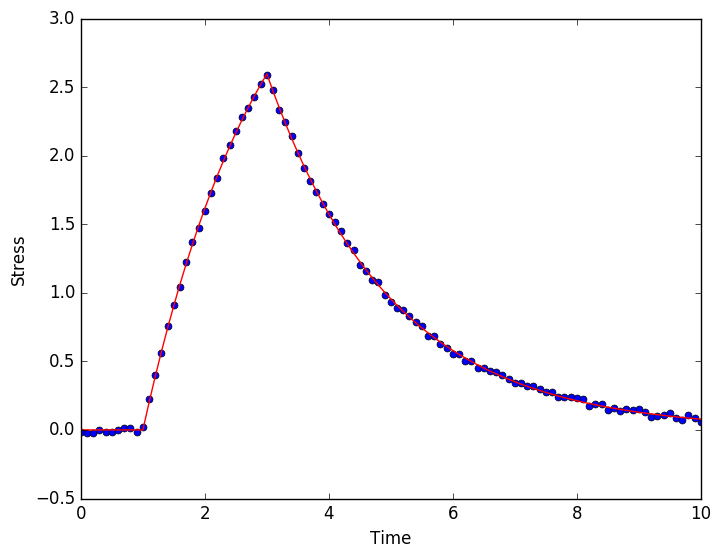

In [9]:
maxwell_predict = modelpredict(data_ext, maxwell_model)

# Now we can plot data and model together for comparison
using PyPlot
plot(data.t,data.σ, "o", markersize = 5);
plot(maxwell_predict.t,maxwell_predict.σ, color = "red");
xlabel("Time");
ylabel("Stress");

**Simulate different model behaviours**

The ability of predicting model's response can be exploited to simulate the behaviour of the model to other external loading conditions. For example, we will explore the response of the fitted model to a creep experiment. 

First we need to define an incomplete RheoTimeData strut, which can be achieved via the data generation functions provided in RHEOS (see section [Generating data](@ref)).

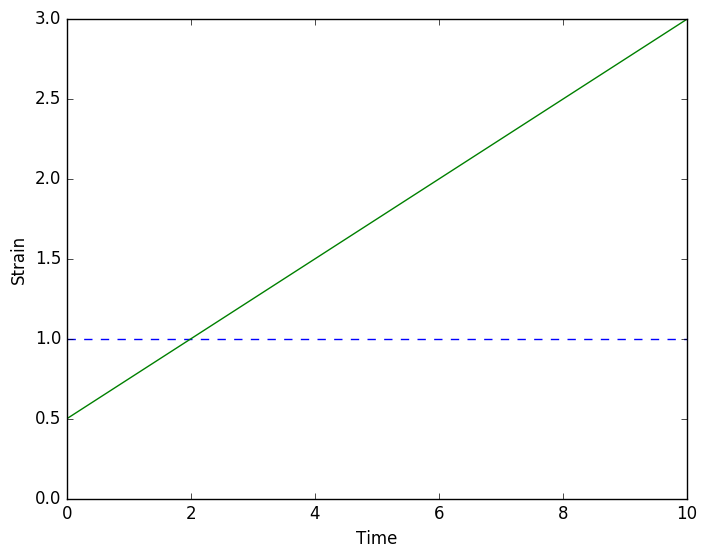

In [7]:
# Define timeline
dσ = timeline()
# and a step in stress
dσ = stressfunction(dσ,hstep())

# we can now predict the creep response of the Maxwell model 
maxwell_creepPredict = modelsteppredict(dσ,maxwell_model)
# Visualisation of the imposed loading
plot(maxwell_creepPredict.t,maxwell_creepPredict.σ, "--")
# Visualisation of the simulated response
plot(maxwell_creepPredict.t,maxwell_creepPredict.ϵ);
xlabel("Time");
ylabel("Strain");

**IMPORTANT NOTE** As for the fitting procedure, if an ideal step loading is assumed, RHEOS provides a dedicated function [`modelsteppredict`](@ref) that requires the same parameters as [`modelpredict`](@ref) which significantly reduces the computating time. 

Similarly, more complex behaviour can be simulated (such as a stairs loading).

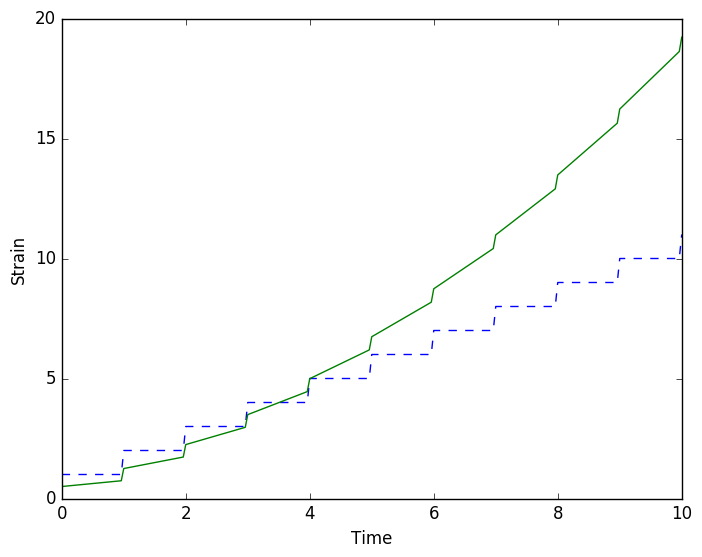

In [8]:
# Define timeline
dσ = timeline()
# and a step in stress
dσ = stressfunction(dσ,stairs())

# we can now predict the stairs response of the Maxwell model 
maxwell_creepPredict = modelpredict(dσ,maxwell_model)
# Plotting
plot(maxwell_creepPredict.t,maxwell_creepPredict.σ, "--")
plot(maxwell_creepPredict.t,maxwell_creepPredict.ϵ);
xlabel("Time");
ylabel("Strain");